In [1]:
# Import the Hugging Face transformer tokenizer and model for sequence classification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch  # PyTorch for deep learning operations
import scipy  # Scientific computing library

# Importing data manipulation and visualization libraries
import pandas as pd  # Pandas for handling structured data (DataFrames)
import numpy as np  # NumPy for numerical computations
import matplotlib.pyplot as plt  # Matplotlib for data visualization

from copy import deepcopy as dc  # Deep copy to avoid modifying original objects
import re  # Regular expressions for text processing

from sklearn.preprocessing import MinMaxScaler # Importing a scaler for feature normalization
from sklearn.metrics import mean_absolute_error # Importing mean_absolute_error metric

# Importing TensorFlow/Keras for building and training deep learning models
from tensorflow.keras.models import Sequential  # Sequential API for building models
from tensorflow.keras.optimizers import Adam  # Adam optimizer for training
from tensorflow.keras import layers  # Keras layers for model architecture
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  
# EarlyStopping prevents overfitting by stopping training when performance degrades
# ReduceLROnPlateau decreases learning rate if the model stops improving

C:\Users\yanbl\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load Articles and perform Sentiment Analysis

In [2]:
df_articles = pd.read_csv('AAPL_articles.csv') # Load CSV with article titles
df_articles.head()

,Date,Title
0,2025-02-14,"Morning Brew: Nvidia Exits Stakes, Retail Sale..."
1,2025-02-14,Apple (AAPL) Partners with Alibaba and Baidu t...
2,2025-02-14,Warren Buffett's Berkshire Takes Stake in Cons...
3,2025-02-14,"Apple's Strategic China AI Moves: A ""Big Step ..."
4,2025-02-14,"Apple Plans AI Rollout in China by May, Teams ..."


Sentiment Analysis using a HuggingFace model

In [3]:
# Load the tokenizer and model for sentiment analysis

model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define sentiment analysis function
def sentiment_analysis(text: str) -> tuple[float, float, float, str]:
    with torch.no_grad():  # Disable gradient computation for inference
        inputs = tokenizer(
            text, return_tensors="pt", padding=True, truncation=True, max_length=512
        ).to(device)  # Move input tensors to the same device as the model
        
        outputs = model(**inputs)  # Get model predictions
        logits = outputs.logits  # Extract raw prediction scores (logits)

        # Convert logits to numpy array (on CPU) before applying softmax
        scores = {
            k: v
            for k, v in zip(
                model.config.id2label.values(),  # Get sentiment labels
                scipy.special.softmax(logits.cpu().numpy().squeeze(), axis=0)  # Move logits to CPU before processing
            )
        }

        return (
            scores["positive"],  # Probability of positive sentiment
            scores["negative"],  # Probability of negative sentiment
            scores["neutral"],  # Probability of neutral sentiment
            max(scores, key=scores.get)  # Sentiment label with the highest probability
        )
    
# Apply sentiment analysis function to the 'Title' column and store results in new columns
df_articles[["positive_score", "negative_score", "neutral_score", "sentiment"]] = (
    df_articles["Title"].apply(sentiment_analysis).apply(pd.Series)  # Convert tuple output to DataFrame columns
)

# Compute a final sentiment score by subtracting negative sentiment probability from positive sentiment probability
df_articles["score"] = df_articles["positive_score"] - df_articles["negative_score"]


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
df_articles.head()

,Date,Title,positive_score,negative_score,neutral_score,sentiment,score
0,2025-02-14,"Morning Brew: Nvidia Exits Stakes, Retail Sale...",0.032715,0.142883,0.824402,neutral,-0.110169
1,2025-02-14,Apple (AAPL) Partners with Alibaba and Baidu t...,0.511125,0.006851,0.482024,positive,0.504274
2,2025-02-14,Warren Buffett's Berkshire Takes Stake in Cons...,0.058607,0.006828,0.934565,neutral,0.051779
3,2025-02-14,"Apple's Strategic China AI Moves: A ""Big Step ...",0.696883,0.004852,0.298265,positive,0.692032
4,2025-02-14,"Apple Plans AI Rollout in China by May, Teams ...",0.243970,0.008856,0.747174,neutral,0.235114


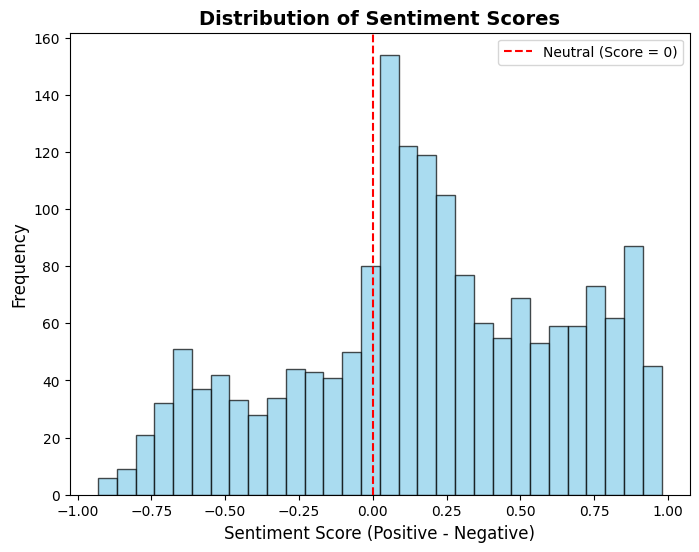

In [5]:
plt.figure(figsize=(8, 6))  # Set the figure size

# Plot the histogram of sentiment scores
plt.hist(df_articles['score'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Add a title and labels
plt.title("Distribution of Sentiment Scores", fontsize=14, fontweight='bold')
plt.xlabel("Sentiment Score (Positive - Negative)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Add a vertical line at 0 to indicate the neutral sentiment threshold
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5, label="Neutral (Score = 0)")

# Add a legend
plt.legend()

# Show the plot
plt.show()


Feature Engineering

In [6]:
df_articles.drop(columns=['Title', 'sentiment'], axis=1, inplace=True) # Keep only numerical columns
df_articles

,Date,positive_score,negative_score,neutral_score,score
0,2025-02-14,0.032715,0.142883,0.824402,-0.110169
1,2025-02-14,0.511125,0.006851,0.482024,0.504274
2,2025-02-14,0.058607,0.006828,0.934565,0.051779
3,2025-02-14,0.696883,0.004852,0.298265,0.692032
4,2025-02-14,0.243970,0.008856,0.747174,0.235114
...,...,...,...,...,...
1745,2023-01-04,0.906021,0.002943,0.091036,0.903078
1746,2023-01-04,0.010366,0.876844,0.112790,-0.866477
1747,2023-01-03,0.176757,0.006645,0.816598,0.170112
1748,2023-01-03,0.068844,0.255930,0.675226,-0.187085


In [7]:
df_group = df_articles.groupby('Date').mean().reset_index() # Aggregate the mean per each day
df_group


,Date,positive_score,negative_score,neutral_score,score
0,2023-01-03,0.097028,0.240583,0.662389,-0.143555
1,2023-01-04,0.458193,0.439893,0.101913,0.018300
2,2023-01-06,0.052348,0.009256,0.938396,0.043091
3,2023-01-09,0.148969,0.280217,0.570814,-0.131248
4,2023-01-11,0.243023,0.008884,0.748094,0.234139
...,...,...,...,...,...
475,2025-02-10,0.538974,0.009975,0.451051,0.528999
476,2025-02-11,0.521180,0.017699,0.461121,0.503481
477,2025-02-12,0.419088,0.041145,0.539766,0.377943
478,2025-02-13,0.532708,0.054969,0.412322,0.477739


In [8]:
df_group = df_group[['Date', 'score']]
df_group.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480 entries, 0 to 479
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    480 non-null    object 
 1   score   480 non-null    float32
dtypes: float32(1), object(1)
memory usage: 5.8+ KB


In [9]:
df_group.tail()

,Date,score
475,2025-02-10,0.528999
476,2025-02-11,0.503481
477,2025-02-12,0.377943
478,2025-02-13,0.477739
479,2025-02-14,0.256862


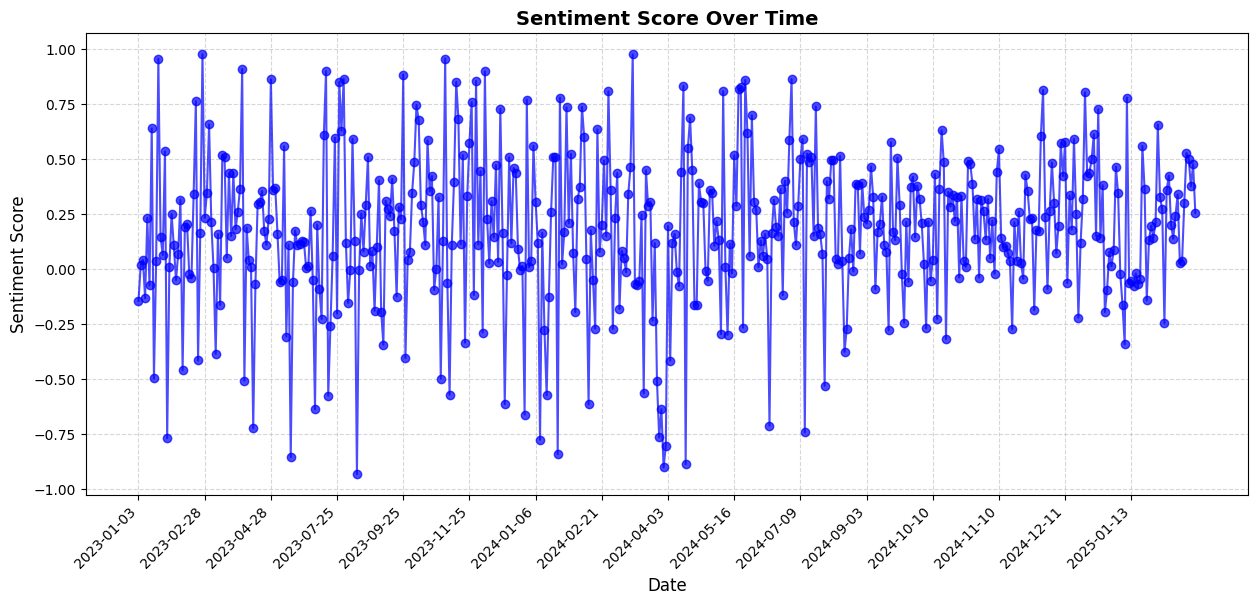

In [10]:
# Ensure the DataFrame is sorted by date in ascending order
df_group = df_group.sort_values(by='Date')

plt.figure(figsize=(15, 6))  # Adjusted figure size for better readability

# Plot sentiment scores over time
plt.plot(df_group['Date'], df_group['score'], marker='o', linestyle='-', color='b', alpha=0.7)

# Label axes
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)
plt.title("Sentiment Score Over Time", fontsize=14, fontweight="bold")

# Show x-axis labels only for every 30th date
plt.xticks(df_group['Date'].iloc[::30], rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

In [11]:
df_prices = pd.read_csv('AAPL_historic_prices.csv') # Load CSV with market prices
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11135 entries, 0 to 11134
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    11135 non-null  object 
 1   Open    11135 non-null  float64
 2   High    11135 non-null  float64
 3   Low     11135 non-null  float64
 4   Close   11135 non-null  float64
 5   Volume  11135 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 522.1+ KB


In [12]:
df_prices.tail()

,Date,Open,High,Low,Close,Volume
11130,10-02-2025,229.570007,230.589996,227.199997,227.649994,33115600
11131,11-02-2025,228.199997,235.229996,228.130005,232.619995,53718400
11132,12-02-2025,231.199997,236.960007,230.679993,236.869995,45243300
11133,13-02-2025,236.910004,242.339996,235.570007,241.529999,53614100
11134,14-02-2025,241.250000,245.550003,240.990005,244.600006,40838100


In [13]:
df_prices = df_prices[['Date', 'Close']] # Keep only Data and Close columns
df_prices

,Date,Close
0,12-12-1980,0.128348
1,15-12-1980,0.121652
2,16-12-1980,0.112723
3,17-12-1980,0.115513
4,18-12-1980,0.118862
...,...,...
11130,10-02-2025,227.649994
11131,11-02-2025,232.619995
11132,12-02-2025,236.869995
11133,13-02-2025,241.529999


In [14]:
df_group['Date'] = pd.to_datetime(df_group['Date']) # Convert to datetime

df_group['Date'].max() # Get lastest date to merge with other CSV


Timestamp('2025-02-14 00:00:00')

In [15]:
df_prices['Date'] = pd.to_datetime(df_prices['Date'], format='%d-%m-%Y')
df_prices.tail()

,Date,Close
11130,2025-02-10,227.649994
11131,2025-02-11,232.619995
11132,2025-02-12,236.869995
11133,2025-02-13,241.529999
11134,2025-02-14,244.600006


In [16]:
df_prices = df_prices[df_prices['Date'] >= df_group['Date'].min()].dropna() # Keep the oldest date to be equal between the two datasets
df_prices = df_prices[df_prices['Date'] <= df_group['Date'].max()].dropna() # Keep the latest date to be equal between the two datasets

print(df_prices.shape)
df_prices.tail()

(532, 2)


,Date,Close
11130,2025-02-10,227.649994
11131,2025-02-11,232.619995
11132,2025-02-12,236.869995
11133,2025-02-13,241.529999
11134,2025-02-14,244.600006


In [17]:
df_merged = pd.merge(df_prices, df_group, on='Date', how='left').dropna() # Merge the datasets and keep rows where we have closing price and score
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 531
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    379 non-null    datetime64[ns]
 1   Close   379 non-null    float64       
 2   score   379 non-null    float32       
dtypes: datetime64[ns](1), float32(1), float64(1)
memory usage: 10.4 KB


In [18]:
df_merged = df_merged.astype({col: 'float64' for col in df_merged.select_dtypes('float').columns}) # Convert to float64 to have same dtype
df_merged.dropna(inplace=True)
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 379 entries, 0 to 531
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    379 non-null    datetime64[ns]
 1   Close   379 non-null    float64       
 2   score   379 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 11.8 KB


Shift dataframe

In [19]:
def prepare_dataframe_for_lstm(df, n_steps, column_name):
    """
    Prepares a DataFrame for LSTM by creating lag features (time steps).

    Parameters:
    df (pd.DataFrame): Input DataFrame.
    n_steps (int): Number of previous time steps to include as features.
    column_name (str): Name of the target column to create lagged values for.

    Returns:
    pd.DataFrame: Modified DataFrame with lag features.
    """
    df = dc(df)  # Create a deep copy to avoid modifying the original DataFrame

    # Generate lagged features for the given column
    for i in range(1, n_steps + 1):
        df[f'{column_name}(t-{i})'] = df[column_name].shift(i)
    
    df.dropna(inplace=True)  # Remove rows with NaN values due to shifting

    return df


In [20]:
# Example usage:
lookback = 60
shifted_df = prepare_dataframe_for_lstm(df_merged, lookback, 'Close') # Shift Close value
shifted_df = prepare_dataframe_for_lstm(shifted_df, lookback, 'score') # Shift score value
shifted_df.head()

,Date,Close,score,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7),...,score(t-51),score(t-52),score(t-53),score(t-54),score(t-55),score(t-56),score(t-57),score(t-58),score(t-59),score(t-60)
218,2023-11-14,187.440002,0.684489,184.800003,182.410004,182.889999,181.820007,176.649994,177.570007,173.970001,...,0.609184,-0.225078,-0.088877,0.203746,-0.636279,-0.049613,0.265919,0.014938,0.122527,0.127645
221,2023-11-17,189.690002,0.113979,187.440002,184.800003,182.410004,182.889999,181.820007,176.649994,177.570007,...,0.901177,0.609184,-0.225078,-0.088877,0.203746,-0.636279,-0.049613,0.265919,0.014938,0.122527
222,2023-11-20,191.449997,0.519524,189.690002,187.440002,184.800003,182.410004,182.889999,181.820007,176.649994,...,-0.573935,0.901177,0.609184,-0.225078,-0.088877,0.203746,-0.636279,-0.049613,0.265919,0.014938
223,2023-11-21,190.639999,-0.333078,191.449997,189.690002,187.440002,184.800003,182.410004,182.889999,181.820007,...,-0.256716,-0.573935,0.901177,0.609184,-0.225078,-0.088877,0.203746,-0.636279,-0.049613,0.265919
225,2023-11-24,189.970001,0.334002,190.639999,191.449997,189.690002,187.440002,184.800003,182.410004,182.889999,...,0.598723,-0.256716,-0.573935,0.901177,0.609184,-0.225078,-0.088877,0.203746,-0.636279,-0.049613


In [21]:
shifted_df.shape

(259, 123)

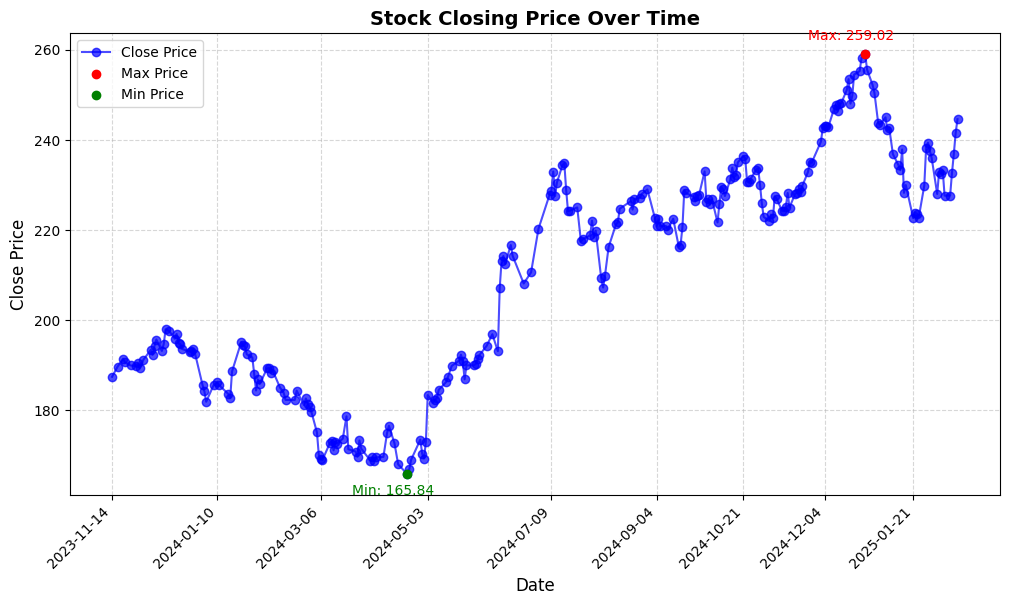

In [22]:
plt.figure(figsize=(12, 6))  # Set figure size for better visibility

# Plot closing prices over time
plt.plot(shifted_df['Date'], shifted_df['Close'], marker='o', linestyle='-', color='b', alpha=0.7, label="Close Price")

# Add title and labels
plt.title("Stock Closing Price Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Close Price", fontsize=12)

# Show x-axis labels only for every 30th date to avoid overcrowding
plt.xticks(shifted_df['Date'].iloc[::30], rotation=45, ha='right')

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Highlight the maximum and minimum closing prices
plt.scatter(shifted_df['Date'][shifted_df['Close'].idxmax()], shifted_df['Close'].max(), 
            color='red', label="Max Price", zorder=3)
plt.scatter(shifted_df['Date'][shifted_df['Close'].idxmin()], shifted_df['Close'].min(), 
            color='green', label="Min Price", zorder=3)

# Add annotations for max and min prices
plt.annotate(f"Max: {shifted_df['Close'].max():.2f}", 
            (shifted_df['Date'][shifted_df['Close'].idxmax()], shifted_df['Close'].max()), 
            textcoords="offset points", xytext=(-10,10), ha='center', fontsize=10, color='red')

plt.annotate(f"Min: {shifted_df['Close'].min():.2f}", 
            (shifted_df['Date'][shifted_df['Close'].idxmin()], shifted_df['Close'].min()), 
            textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=10, color='green')

# Add legend
plt.legend()

# Show the plot
plt.show()


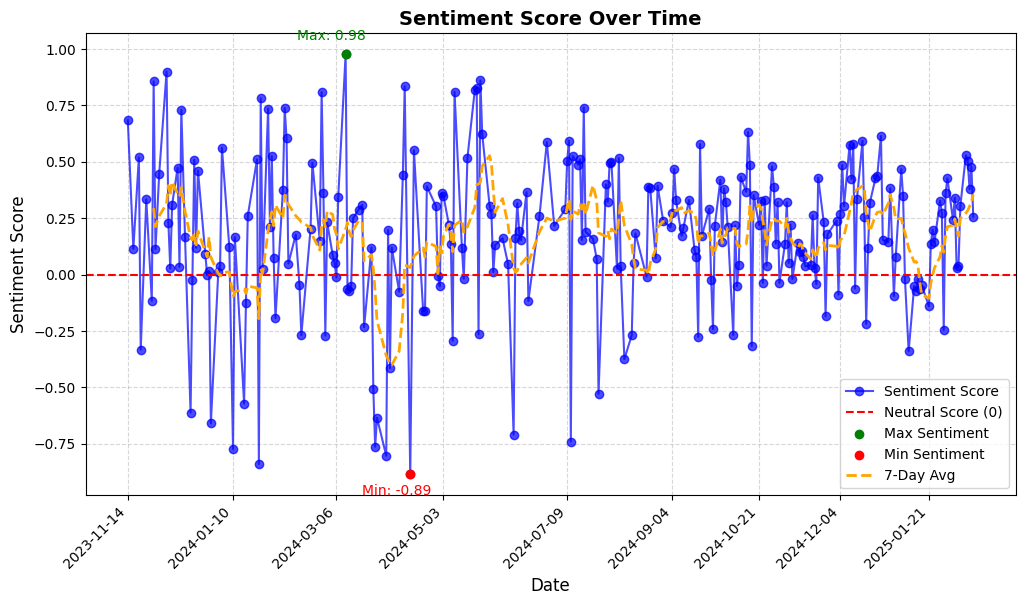

In [23]:
plt.figure(figsize=(12, 6))  # Set figure size for better visibility

# Plot sentiment scores over time
plt.plot(shifted_df['Date'], shifted_df['score'], marker='o', linestyle='-', color='b', alpha=0.7, label="Sentiment Score")

# Add title and labels
plt.title("Sentiment Score Over Time", fontsize=14, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sentiment Score", fontsize=12)

# Show x-axis labels only for every 30th date to avoid overcrowding
plt.xticks(shifted_df['Date'].iloc[::30], rotation=45, ha='right')

# Add a horizontal line at 0 to highlight neutral sentiment
plt.axhline(0, color='red', linestyle='dashed', linewidth=1.5, label="Neutral Score (0)")

# Highlight the maximum and minimum sentiment scores
plt.scatter(shifted_df['Date'][shifted_df['score'].idxmax()], shifted_df['score'].max(), 
            color='green', label="Max Sentiment", zorder=3)
plt.scatter(shifted_df['Date'][shifted_df['score'].idxmin()], shifted_df['score'].min(), 
            color='red', label="Min Sentiment", zorder=3)

# Annotate max and min sentiment scores
plt.annotate(f"Max: {shifted_df['score'].max():.2f}", 
            (shifted_df['Date'][shifted_df['score'].idxmax()], shifted_df['score'].max()), 
            textcoords="offset points", xytext=(-10,10), ha='center', fontsize=10, color='green')

plt.annotate(f"Min: {shifted_df['score'].min():.2f}", 
            (shifted_df['Date'][shifted_df['score'].idxmin()], shifted_df['score'].min()), 
            textcoords="offset points", xytext=(-10,-15), ha='center', fontsize=10, color='red')

# Add a rolling average trendline (e.g., 7-day moving average for smoothing)
shifted_df["rolling_avg"] = shifted_df["score"].rolling(window=7).mean()
plt.plot(shifted_df["Date"], shifted_df["rolling_avg"], color="orange", linestyle="dashed", linewidth=2, label="7-Day Avg")

# Add grid for better readability
plt.grid(True, linestyle="--", alpha=0.5)

# Add legend
plt.legend()

# Show the plot
plt.show()


In [24]:
shifted_df.set_index('Date', inplace=True) # Set Date as the index column

In [25]:
def invert_lagged_columns(df):
    """
    Reorders the columns of a DataFrame starting from the highest lagged column
    (e.g., 'close(t-3)') and ending with the base column (e.g., 'close').
    Preserves other non-lagged columns.
    """
    # Identify all columns that match the pattern for lagged columns
    lag_columns = [col for col in df.columns if re.match(r'.*\(t-\d+\)$', col)]
    
    if not lag_columns:
        print("Warning: No lagged columns found. Returning the original DataFrame.")
        return df

    # Sort lagged columns from highest to lowest lag
    lag_columns_sorted = sorted(lag_columns, key=lambda x: int(re.search(r'\(t-(\d+)\)$', x).group(1)), reverse=True)

    # Identify all non-lagged columns
    non_lag_columns = [col for col in df.columns if col not in lag_columns]

    # Keep all non-lagged columns instead of just one
    column_order = lag_columns_sorted + non_lag_columns

    # Return reordered DataFrame
    return df[column_order]

In [26]:
shifted_df = invert_lagged_columns(shifted_df)
shifted_df.head()

,Close(t-60),score(t-60),Close(t-59),score(t-59),Close(t-58),score(t-58),Close(t-57),score(t-57),Close(t-56),score(t-56),...,score(t-4),Close(t-3),score(t-3),Close(t-2),score(t-2),Close(t-1),score(t-1),Close,score,rolling_avg
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,175.429993,0.127645,177.250000,0.122527,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,...,0.958664,182.889999,-0.061678,182.410004,-0.569756,184.800003,0.852767,187.440002,0.684489,NaN
2023-11-17,177.250000,0.122527,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,...,-0.061678,182.410004,-0.569756,184.800003,0.852767,187.440002,0.684489,189.690002,0.113979,NaN
2023-11-20,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,...,-0.569756,184.800003,0.852767,187.440002,0.684489,189.690002,0.113979,191.449997,0.519524,NaN
2023-11-21,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,185.270004,-0.088877,...,0.852767,187.440002,0.684489,189.690002,0.113979,191.449997,0.519524,190.639999,-0.333078,NaN
2023-11-24,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,185.270004,-0.088877,188.059998,-0.225078,...,0.684489,189.690002,0.113979,191.449997,0.519524,190.639999,-0.333078,189.970001,0.334002,NaN


In [27]:
# Re order columns and put Close last
new_cols = [col for col in shifted_df.columns if col != 'Close'] + ['Close']
shifted_df = shifted_df[new_cols]
shifted_df.head()

,Close(t-60),score(t-60),Close(t-59),score(t-59),Close(t-58),score(t-58),Close(t-57),score(t-57),Close(t-56),score(t-56),...,score(t-4),Close(t-3),score(t-3),Close(t-2),score(t-2),Close(t-1),score(t-1),score,rolling_avg,Close
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-14,175.429993,0.127645,177.250000,0.122527,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,...,0.958664,182.889999,-0.061678,182.410004,-0.569756,184.800003,0.852767,0.684489,NaN,187.440002
2023-11-17,177.250000,0.122527,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,...,-0.061678,182.410004,-0.569756,184.800003,0.852767,187.440002,0.684489,0.113979,NaN,189.690002
2023-11-20,179.580002,0.014938,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,...,-0.569756,184.800003,0.852767,187.440002,0.684489,189.690002,0.113979,0.519524,NaN,191.449997
2023-11-21,183.949997,0.265919,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,185.270004,-0.088877,...,0.852767,187.440002,0.684489,189.690002,0.113979,191.449997,0.519524,-0.333078,NaN,190.639999
2023-11-24,186.009995,-0.049613,184.919998,-0.636279,185.009995,0.203746,185.270004,-0.088877,188.059998,-0.225078,...,0.684489,189.690002,0.113979,191.449997,0.519524,190.639999,-0.333078,0.334002,NaN,189.970001


In [28]:
shifted_df.drop(columns=('rolling_avg'), inplace=True) # Drop rolling_avg column that was created earlier
shifted_df.shape

(259, 122)

Dataframe Conversions

In [29]:
shifted_df = shifted_df.to_numpy()
shifted_df

array([[1.75429993e+02, 1.27644956e-01, 1.77250000e+02, ...,
        8.52766812e-01, 6.84489131e-01, 1.87440002e+02],
       [1.77250000e+02, 1.22527450e-01, 1.79580002e+02, ...,
        6.84489131e-01, 1.13978744e-01, 1.89690002e+02],
       [1.79580002e+02, 1.49382502e-02, 1.83949997e+02, ...,
        1.13978744e-01, 5.19523680e-01, 1.91449997e+02],
       ...,
       [2.24229996e+02, 1.01773426e-01, 2.25119995e+02, ...,
        5.03481030e-01, 3.77943039e-01, 2.36869995e+02],
       [2.25119995e+02, 1.05438955e-01, 2.28220001e+02, ...,
        3.77943039e-01, 4.77739155e-01, 2.41529999e+02],
       [2.28220001e+02, 7.62492865e-02, 2.25000000e+02, ...,
        4.77739155e-01, 2.56861806e-01, 2.44600006e+02]])

In [30]:
X = shifted_df[:, :-1]  # All columns except last
y = shifted_df[:, -1:]  # Last column, keep 2D shape with :-1

X.shape, y.shape

((259, 121), (259, 1))

In [31]:
# Scale between -1 and 1 because the sentiment score can also get negative values
X_scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

X_scaler, y_scaler

(MinMaxScaler(feature_range=(-1, 1)), MinMaxScaler(feature_range=(-1, 1)))

In [32]:
# Scale X and y separately
X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

X_scaled.shape, y_scaled.shape

((259, 121), (259, 1))

In [33]:
# Create train, val, test splits
q_80 = int(len(X) * 0.8)
q_90 = int(len(X) * 0.9) 

X_train, y_train = X_scaled[:q_80], y_scaled[:q_80]
X_val, y_val = X_scaled[q_80:q_90], y_scaled[q_80:q_90]
X_test, y_test = X_scaled[q_90:], y_scaled[q_90:]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((207, 121), (207, 1), (26, 121), (26, 1), (26, 121), (26, 1))

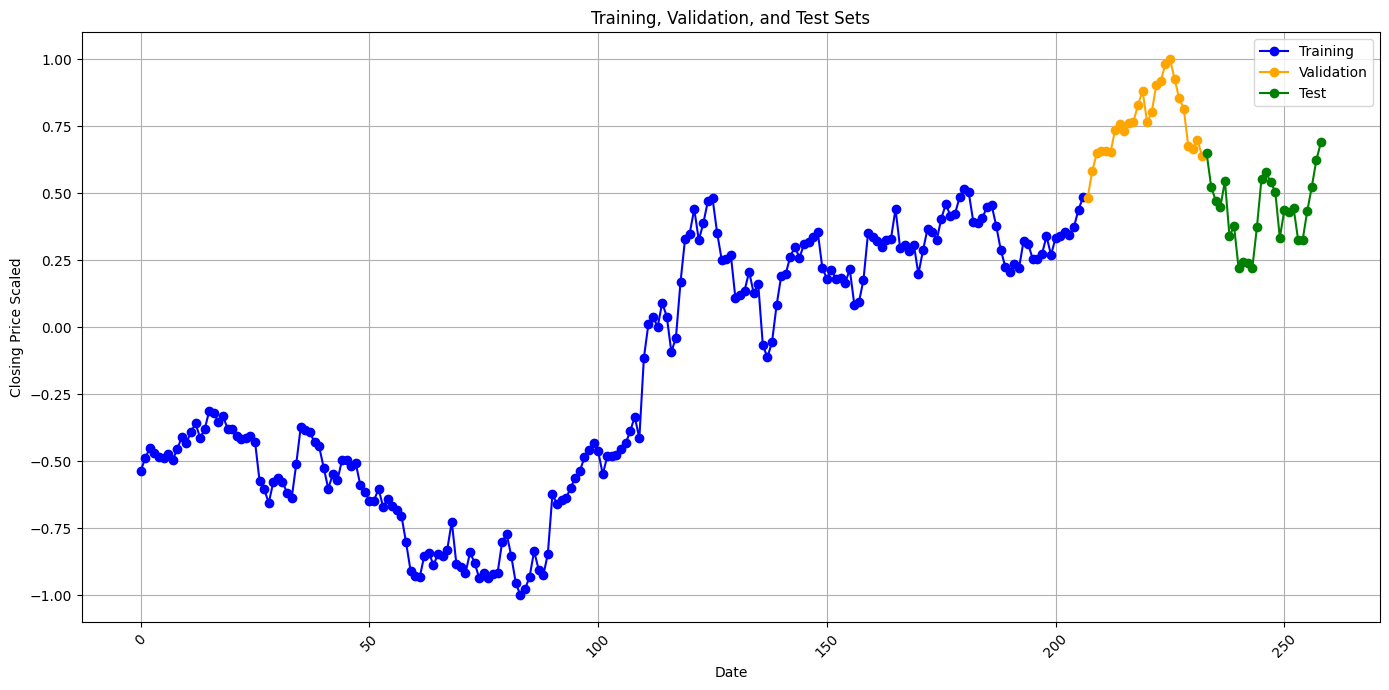

In [34]:
# Ensure DataFrame is sorted by Date
df_articles = df_articles.sort_index()

# Extract all dates corresponding to y values BEFORE the split
dates = df_articles.index[:len(y_train) + len(y_val) + len(y_test)]

# Split dates correctly
dates_train = dates[:len(y_train)]
dates_val = dates[len(y_train):len(y_train) + len(y_val)]
dates_test = dates[len(y_train) + len(y_val):]

# Ensure length consistency
assert len(dates_train) == len(y_train), "Mismatch in training dates and values!"
assert len(dates_val) == len(y_val), "Mismatch in validation dates and values!"
assert len(dates_test) == len(y_test), "Mismatch in test dates and values!"

# Plot the data
plt.figure(figsize=(14, 7))

plt.plot(dates_train, y_train, label='Training', color='blue', marker='o')
plt.plot(dates_val, y_val, label='Validation', color='orange', marker='o')
plt.plot(dates_test, y_test, label='Test', color='green', marker='o')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Closing Price Scaled')
plt.title('Training, Validation, and Test Sets')
plt.legend()

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Improve layout
plt.tight_layout()
plt.grid(True)  # Optional: Adds grid for better visualization

plt.show()

In [35]:
# LSTM models expect a 3D input with the shape (samples, timesteps, features)

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

X_train.shape, X_val.shape, X_test.shape

((207, 121, 1), (26, 121, 1), (26, 121, 1))

LSTM Model

In [36]:
model = Sequential([
                    # Input layer: Defines the input shape based on the training data
                    layers.Input((X_train.shape[1], 1)),  # Input shape is (number of features, 1), where X_train.shape[1] is the number of features
                    # First LSTM layer: This layer will learn sequential patterns from the input data
                    layers.LSTM(128, return_sequences=True),  # 128 units and return sequences for the next LSTM layer
                    # Dropout layer: Helps prevent overfitting by randomly setting a fraction of input units to zero during training
                    layers.Dropout(0.2),  # Dropout rate of 20%
                    layers.LSTM(64),
                    layers.Dropout(0.2),
                    #Fully connected (Dense) layer with 64 neurons and ReLU activation
                    layers.Dense(64, activation='relu'),  # ReLU activation function to introduce non-linearity
                    layers.Dropout(0.2),
                    layers.Dense(64, activation='relu'),
                    # Output layer: Predicts a single value (regression task)
                    layers.Dense(1)  # Output layer with a single unit for regression
])

# Display the model architecture summary
model.summary()  # Prints a summary of the model including layers, output shapes, and parameters

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 121, 128)       │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 121, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,353 (485.75 KB)

 Trainable params: 124,353 (485.75 KB)

 Non-trainable params: 0 (0.00 B)

Hyperparameters

In [37]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Monitor validation loss to determine stopping
        patience=15,  # Stop training if no improvement for 15 epochs (increased patience)
        restore_best_weights=True,  # Restore the model weights from the epoch with the best validation loss
        mode='min'  # Stop when 'val_loss' stops decreasing (lower is better)
    ),
    ReduceLROnPlateau(  # Reduce learning rate when validation loss plateaus
        monitor='val_loss',  # Monitor validation loss
        factor=0.2,  # Reduce learning rate by a factor of 0.2 when triggered
        patience=5,  # Wait 5 epochs before reducing the learning rate if no improvement
        min_lr=0.00001  # Set a lower bound for the learning rate to prevent it from getting too small
    )
]


In [38]:
model.compile(
    loss='huber',  # Use Huber loss, which is less sensitive to outliers than MSE
    optimizer=Adam(learning_rate=0.001),  # Adam optimizer with a learning rate of 0.001
    metrics=['mean_absolute_error']  # Track MAE (Mean Absolute Error) as an evaluation metric
)


In [39]:
history = model.fit(
    X_train,  # Training data (features)
    y_train,  # Training data (labels)
    validation_data=(X_val, y_val),  # Validation data to monitor performance during training
    epochs=50,  # Number of training epochs (iterations over the entire dataset)
    batch_size=16,  # Number of samples per gradient update (mini-batch size)
    verbose=1,  # Display progress logs during training (1 = progress bar)
    callbacks=callbacks  # List of callbacks (EarlyStopping and ReduceLROnPlateau) to control training behavior
)

Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 128ms/step - loss: 0.0892 - mean_absolute_error: 0.3628 - val_loss: 0.0413 - val_mean_absolute_error: 0.2701 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0204 - mean_absolute_error: 0.1672 - val_loss: 0.0335 - val_mean_absolute_error: 0.2400 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0163 - mean_absolute_error: 0.1374 - val_loss: 0.0429 - val_mean_absolute_error: 0.2789 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0158 - mean_absolute_error: 0.1365 - val_loss: 0.0429 - val_mean_absolute_error: 0.2793 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0147 - mean_absolute_error: 0.1342 - val_loss: 0.0624 - val_mean_absolute_error: 0.3416 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0169 - mean_absolute_error: 0.1472 - val_loss: 0.0819 - val_mean_absolute

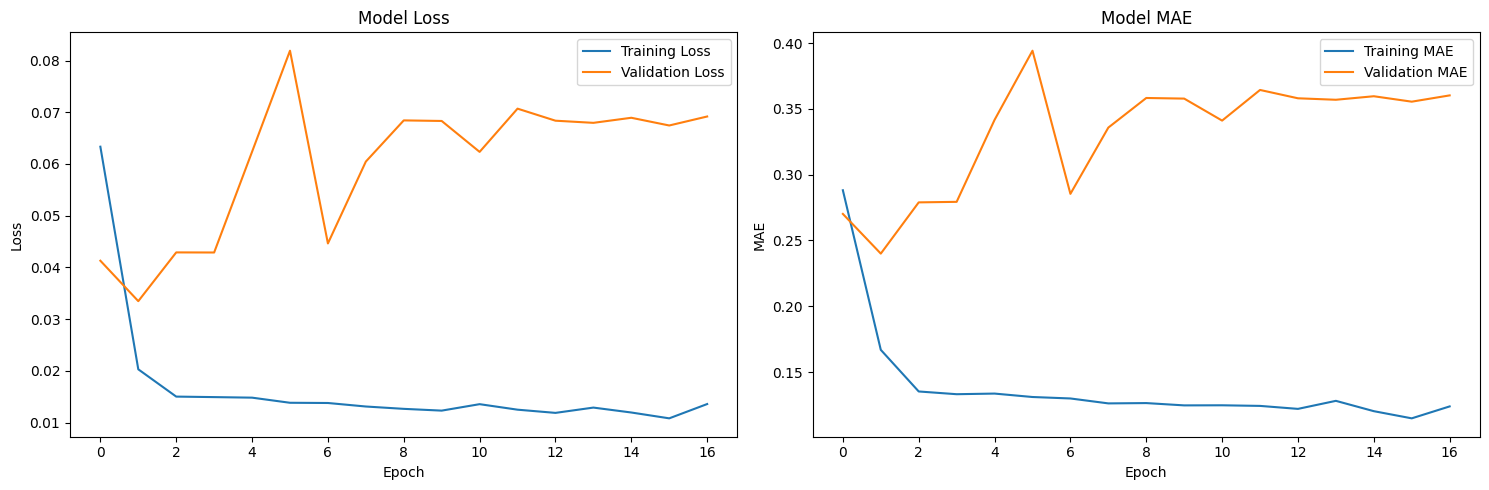

In [40]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
    
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
    
plt.tight_layout()
plt.show()

Evaluation

In [41]:
# Evaluate the model on the test data (X_test and y_test) without printing the verbose output
test_loss, test_mae = model.evaluate(
    X_test,  # Test features
    y_test,  # True labels for the test data
    verbose=0  # Set verbose to 0 to suppress the output during evaluation
)

# Print the test loss and test Mean Absolute Error (MAE) with 4 decimal precision
print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}")


Test Loss: 0.0095, Test MAE: 0.1019


Training Evaluation

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step


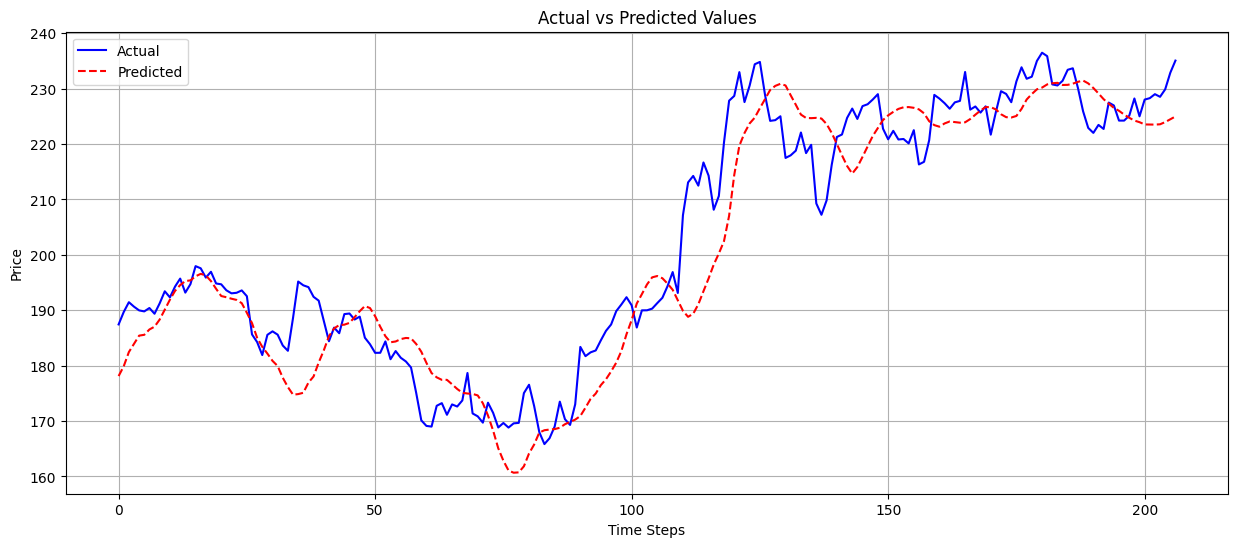

MSE: 59.51
RMSE: 7.71
MAE: 5.87


In [42]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_train)
predictions_unscaled = y_scaler.inverse_transform(predictions)
y_train_unscaled = y_scaler.inverse_transform(y_train)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_train_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_train_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_train_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Validation Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step


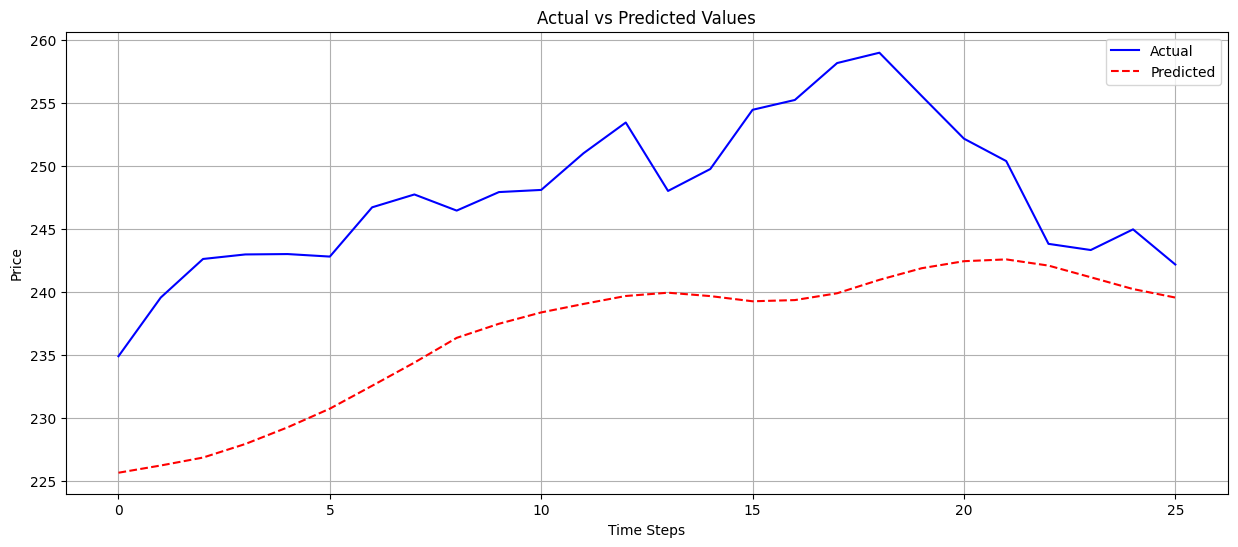

MSE: 145.32
RMSE: 12.05
MAE: 11.18


In [43]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_val)
predictions_unscaled = y_scaler.inverse_transform(predictions)
y_val_unscaled = y_scaler.inverse_transform(y_val)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_val_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_val_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_val_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Test Evaluation

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


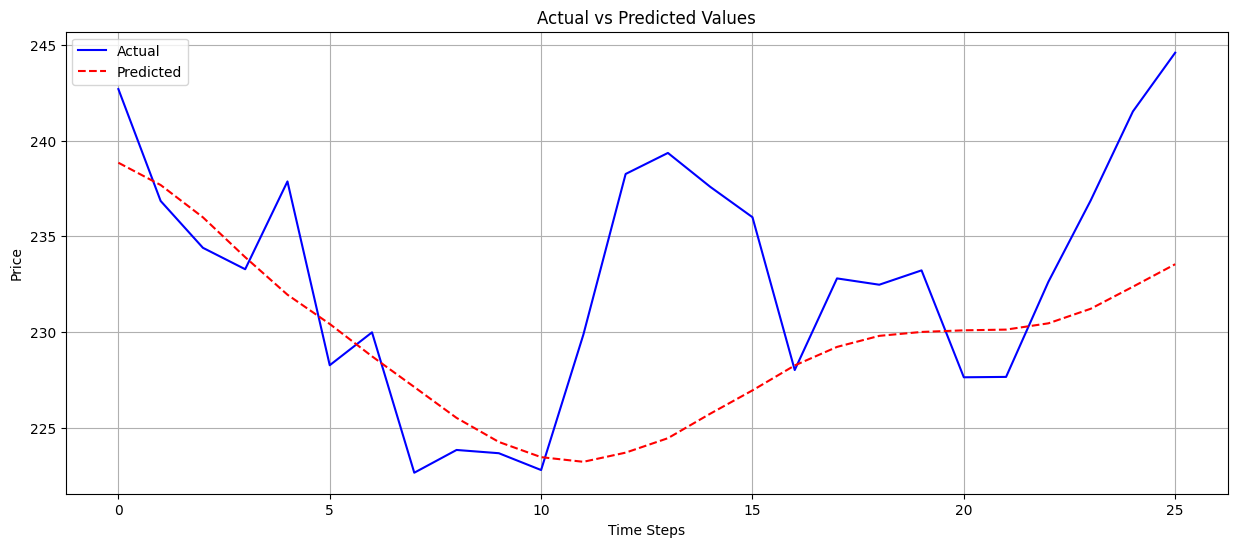

MSE: 41.18
RMSE: 6.42
MAE: 4.75


In [44]:
# First, inverse transform both predictions and actual values
predictions = model.predict(X_test)
predictions_unscaled = y_scaler.inverse_transform(predictions)
y_test_unscaled = y_scaler.inverse_transform(y_test)

# Create a time index (assuming daily data)
time_index = np.arange(len(predictions_unscaled))

# Plot
plt.figure(figsize=(15, 6))
plt.plot(time_index, y_test_unscaled, label='Actual', color='blue')
plt.plot(time_index, predictions_unscaled, label='Predicted', color='red', linestyle='--')
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print some error metrics
mse = np.mean((y_test_unscaled - predictions_unscaled)**2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_test_unscaled - predictions_unscaled))
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'MAE: {mae:.2f}')

Generate and View Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


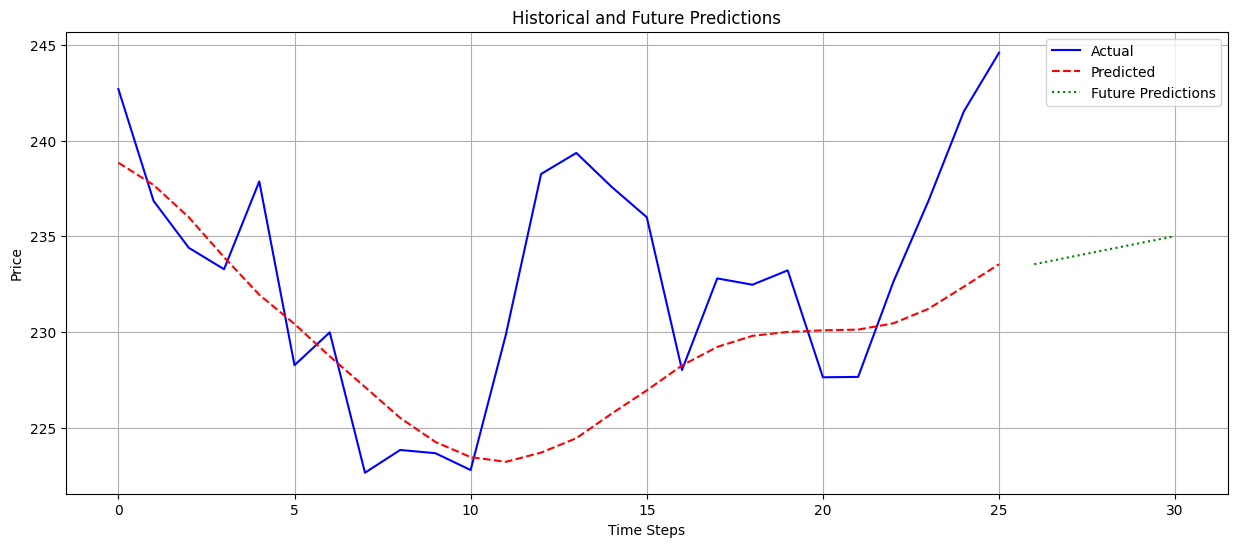


Predicted values for next 5 time steps:
Step 1: 233.54
Step 2: 233.91
Step 3: 234.28
Step 4: 234.65
Step 5: 235.01


In [45]:
# First generate predictions for test set
test_predictions = model.predict(X_test)
test_predictions_unscaled = y_scaler.inverse_transform(test_predictions)
y_test_unscaled = y_scaler.inverse_transform(y_test)

def predict_future_steps(model, last_sequence, n_steps=5, X_scaler=X_scaler, y_scaler=y_scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(n_steps):
        current_reshape = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(current_reshape, verbose=0)
        future_predictions.append(next_pred[0, 0])
        
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]
    
    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return y_scaler.inverse_transform(future_predictions)

# Get the last sequence and predict future
last_sequence = X_test[-1]
future_preds = predict_future_steps(model, last_sequence, n_steps=5)

# Plot
plt.figure(figsize=(15, 6))

# Historical data
plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(test_predictions_unscaled, label='Predicted', color='red', linestyle='--')

# Future predictions
future_indices = np.arange(len(y_test_unscaled), len(y_test_unscaled) + 5)
plt.plot(future_indices, future_preds, label='Future Predictions', color='green', linestyle=':')

plt.title('Historical and Future Predictions')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print predictions
print("\nPredicted values for next 5 time steps:")
for i, pred in enumerate(future_preds, 1):
    print(f"Step {i}: {pred[0]:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


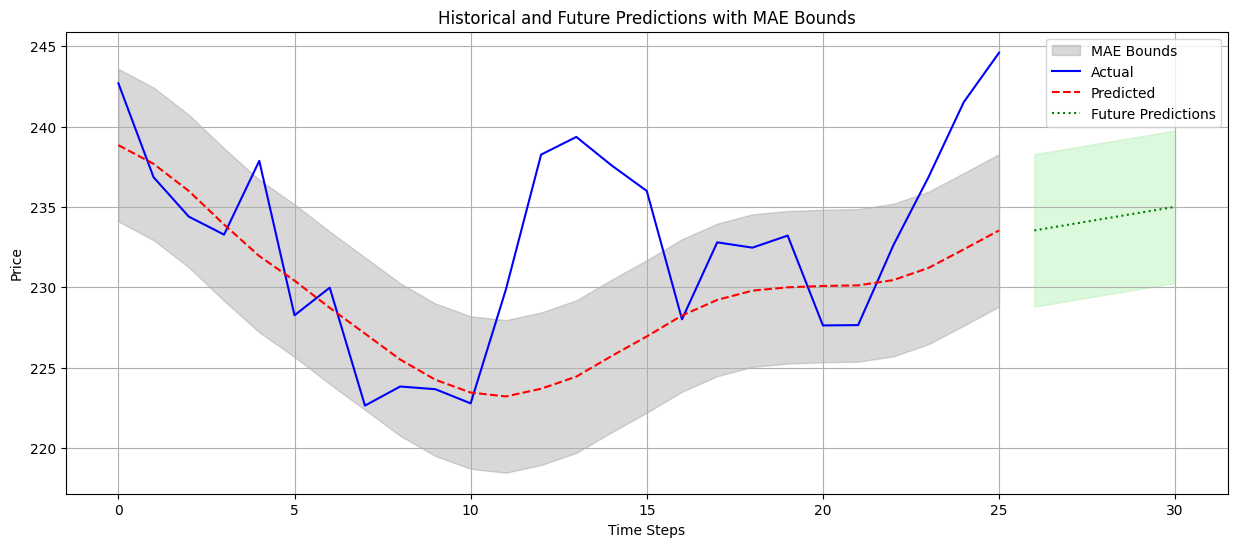


Mean Absolute Error (MAE): 4.75

Predicted values for next 5 time steps (with MAE bounds):

Step | Prediction | Lower Bound | Upper Bound
--------------------------------------------------
Step  1 |     233.54 |     228.80 |     238.29
Step  2 |     233.91 |     229.16 |     238.66
Step  3 |     234.28 |     229.53 |     239.03
Step  4 |     234.65 |     229.90 |     239.39
Step  5 |     235.01 |     230.26 |     239.76


In [46]:
# First generate predictions for test set
test_predictions = model.predict(X_test)
test_predictions_unscaled = y_scaler.inverse_transform(test_predictions)
y_test_unscaled = y_scaler.inverse_transform(y_test)

# Calculate MAE using scaled values
mae = mean_absolute_error(y_test, test_predictions)
mae_unscaled = mean_absolute_error(y_test_unscaled, test_predictions_unscaled)

def predict_future_steps(model, last_sequence, n_steps=5, X_scaler=X_scaler, y_scaler=y_scaler):
    future_predictions = []
    current_sequence = last_sequence.copy()

    for n_steps in range(n_steps):
        current_reshape = current_sequence.reshape((1, current_sequence.shape[0], 1))
        next_pred = model.predict(current_reshape, verbose=0)
        future_predictions.append(next_pred[0, 0])

        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred[0, 0]

    future_predictions = np.array(future_predictions).reshape(-1, 1)
    return y_scaler.inverse_transform(future_predictions)

# Get the last sequence and predict future
last_sequence = X_test[-1]
future_preds = predict_future_steps(model, last_sequence, n_steps=5)

# Plot
plt.figure(figsize=(15, 6))

# Historical data with MAE bounds
plt.fill_between(range(len(y_test_unscaled)), 
                test_predictions_unscaled.flatten() - mae_unscaled, 
                test_predictions_unscaled.flatten() + mae_unscaled, 
                alpha=0.3, color='gray', label='MAE Bounds')

plt.plot(y_test_unscaled, label='Actual', color='blue')
plt.plot(test_predictions_unscaled, label='Predicted', color='red', linestyle='--')

# Future predictions with MAE bounds
future_indices = np.arange(len(y_test_unscaled), len(y_test_unscaled) + 5)
plt.fill_between(future_indices, 
                future_preds.flatten() - mae_unscaled, 
                future_preds.flatten() + mae_unscaled, 
                alpha=0.3, color='lightgreen')

plt.plot(future_indices, future_preds, label='Future Predictions', color='green', linestyle=':')

plt.title('Historical and Future Predictions with MAE Bounds')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Print predictions with MAE bounds
print(f"\nMean Absolute Error (MAE): {mae_unscaled:.2f}")
print("\nPredicted values for next 5 time steps (with MAE bounds):")
print("\nStep | Prediction | Lower Bound | Upper Bound")
print("-" * 50)
for i, pred in enumerate(future_preds, 1):
    lower_bound = pred[0] - mae_unscaled
    upper_bound = pred[0] + mae_unscaled
    print(f"Step {i:2d} | {pred[0]:10.2f} | {lower_bound:10.2f} | {upper_bound:10.2f}")